In [2]:
import glob
import tifffile
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from tqdm import tqdm
import rasterio
from sklearn.metrics import roc_auc_score
from rasterio.plot import show
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import gc
import time
import os
import random
import math
from copy import deepcopy
from functools import partial
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
warnings.simplefilter('ignore')


from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [3]:
train_path =  'train/s2_image/'
mask_path = 'train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [4]:
train_path =  'train/s2_image/'
mask_path = 'train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [5]:
path = 'train/s2_image/train_s2_image_90.tif'

In [6]:
ds = rasterio.open(path)

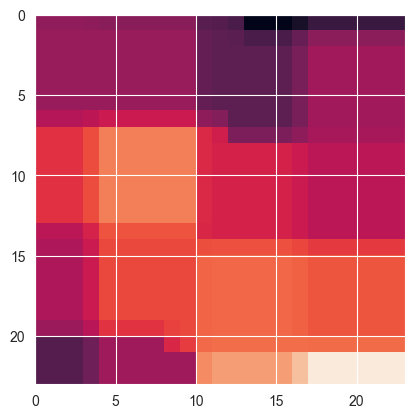

<Axes: >

In [7]:
show((ds, 1))

In [8]:
ds.read(12)

array([[1392.82625192, 1427.61220048, 1549.00970358, 1438.80199676,
        1252.12051541, 1124.77196345, 1002.60303541,  999.54622263,
         960.8109608 ,  947.37164807,  827.65079312,  812.98968406,
         805.83250276,  750.        ,  798.88313184,  936.5       ,
        1064.19387354, 1247.5       , 1247.5       , 1273.78262084,
        1289.        , 1401.57912117, 1433.        ],
       [1406.        , 1441.97007643, 1567.5       , 1455.58072193,
        1266.        , 1125.42344739,  995.5       ,  995.5       ,
         963.57609315,  952.5       ,  834.45578628,  820.        ,
         833.9535181 ,  942.80360943,  994.24010673, 1139.04526549,
        1237.24032955, 1378.20055208, 1378.20055208, 1385.71746365,
        1390.06968158, 1482.65674665, 1508.49783443],
       [1867.12778561, 1804.46942346, 1585.8015697 , 1542.48527093,
        1469.11153825, 1315.48043812, 1173.4917367 , 1173.4917367 ,
        1071.76596351, 1036.47190804,  916.50947509,  901.81878219,
        

In [9]:
ds.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)

In [10]:
data_list = []
for i in range(len(trains)):
    img = tifffile.imread(trains[i]).astype(float)
    msk = tifffile.imread(masks[i]).astype(float)

    reshaped_img = img.reshape(-1, 12) # (23, 23, 12) -> (23*23, 12)
    flatten_mask = msk.reshape(-1,1)   # (23, 23) -> (23*23, 1)

    is_train     = 1
    if i % 5 == 0:  is_train     = 0
    is_train_image = np.full((reshaped_img.shape[0], 1), is_train)

    combine_data = np.hstack((reshaped_img, flatten_mask))
    combine_data = np.hstack((combine_data, is_train_image))

    data_list.append(combine_data)

data_list = np.vstack(data_list)

In [11]:
df = pd.DataFrame(data=data_list, columns= ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','B12', 'Mask', 'is_train'])
df

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,Mask,is_train
0,265.800583,279.066472,488.098252,331.572300,817.002914,2400.280728,3084.914212,3236.613360,3332.798479,3251.691757,1598.907575,818.413402,0.0,0.0
1,265.800583,271.067287,472.501621,322.083156,817.002914,2400.280728,3084.914212,3188.111508,3332.798479,3251.691757,1598.907575,818.413402,0.0,0.0
2,265.800583,240.942322,424.775329,279.931718,784.908433,2322.216009,2998.675982,2906.248048,3251.978778,3251.691757,1549.296809,798.364396,0.0,0.0
3,265.800583,222.820502,411.740847,245.060190,737.346930,2206.530216,2870.877686,2640.218320,3132.210318,3251.691757,1475.777544,768.653340,0.0,0.0
4,378.735906,229.331874,434.090056,254.714547,782.884060,2226.587592,2840.185718,2651.574272,3084.218565,3341.757199,1562.631939,809.818550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133567,1166.000000,1049.347260,1190.897532,1254.509945,1365.000000,1379.000000,1468.000000,1463.018392,1461.000000,1490.000000,2027.000000,1859.000000,0.0,0.0
1133568,1166.000000,1090.473893,1243.402564,1362.630769,1365.000000,1379.000000,1468.000000,1572.583217,1461.000000,1490.000000,2027.000000,1859.000000,0.0,0.0
1133569,1089.344375,1097.961592,1251.727616,1360.179232,1399.362866,1489.137392,1583.130287,1621.304781,1591.402672,1639.199454,2009.671717,1797.029361,0.0,0.0
1133570,905.000000,1018.380712,1222.829764,1265.576354,1482.000000,1754.000000,1860.000000,1952.131222,1905.000000,1998.000000,1968.000000,1648.000000,0.0,0.0


In [12]:
df['is_train'].value_counts()

1.0    905863
0.0    227709
Name: is_train, dtype: int64

In [13]:
train = df.iloc[:,0:12]  #independent columns
test= df.iloc[:,-2]    #target column i.e price range
test
del df
gc.collect()

931


from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10, 'Score'))  #print 10 best features

In [14]:
class Splitter :
    def __init__(self, kfold = True, n_splits = 5, df = pd.DataFrame(), test_size = 0.3 ):
        self.n_splits = n_splits
        self.kfold = kfold
        self.df = df
        self.test_size = test_size

    def split_data(self, X, y, random_state_list):
        if self.kfold == 'skf' :
            for random_state in random_state_list :
                kf = StratifiedKFold(n_splits = self.n_splits, random_State = random_state, shuffle = True)
                for train_index, val_index in tqdm(kf.split(X, self.df)):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index

        elif self.kfold:
            for random_state in random_state_list :
                kf = StratifiedKFold(n_splits = self.n_splits, random_State = random_state, shuffle = True)
                for train_index, val_index in tqdm(kf.split(X, y)):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val,val_index

        else :
            for random_state in random_state_list :
                X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val


In [15]:

n_estimators = 50
scoring = 'roc_auc'

In [16]:

splitter = Splitter(kfold=False, test_size=0.7)
X_train, X_val, y_train, y_val = next(iter(splitter.split_data(train, test, random_state_list=[42])))

In [17]:
class Classifier:
    def __init__(self, target_col, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model(target_col)
        self.models_name = list(self._define_model(target_col).keys())
        self.len_models = len(self.models)

    def _define_model(self, target_col):

        if target_col == 'Mask':
            xgb1_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.00764887595631511,
                'booster': 'gbtree',
                'lambda': 0.0379675844718388,
                'alpha': 0.0127846822376181,
                'subsample': 0.954836600053134,
                'colsample_bytree': 0.303279712350842,
                'max_depth': 9,
                'min_child_weight': 8,
                'eta': 7.78550117314348E-07,
                'gamma': 2.16524511622072E-06,
                'grow_policy': 'lossguide',
                'n_jobs': -1,
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'verbosity': 0,
                'random_state': self.random_state,
            }
            xgb2_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.00610113589892878,
                'booster': 'gbtree',
                'lambda': 8.96906460616343E-08,
                'alpha': 0.179699301214927,
                'subsample': 0.693147524348261,
                'colsample_bytree': 0.201796295242956,
                'max_depth': 7,
                'min_child_weight': 7,
                'eta': 0.491486337405877,
                'gamma': 0.0219744528297816,
                'grow_policy': 'lossguide',
                'n_jobs': -1,
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'verbosity': 0,
                'random_state': self.random_state,
            }
        if self.device == 'gpu':
            xgb1_params['tree_method'] = 'gpu_hist'
            xgb1_params['predictor'] = 'gpu_predictor'
            xgb2_params['tree_method'] = 'gpu_hist'
            xgb2_params['predictor'] = 'gpu_predictor'

        if target_col == 'Mask':
            lgb1_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.0228011747280739,
                'reg_alpha': 5.65344226754958E-08,
                'reg_lambda': 0.0000457329103646115,
                'num_leaves': 41,
                'colsample_bytree': 0.44294848432797,
                'subsample': 0.751451025433351,
                'subsample_freq': 4,
                'min_child_samples': 47,
                'objective': 'binary',
                'metric': 'logloss', # binary_error
                'boosting_type': 'gbdt',
                #'is_unbalance':True,
                # 'n_jobs': -1,
                #'force_row_wise': True,
                'device': self.device,
                'random_state': self.random_state
            }
            lgb2_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.0150317388979459,
                'reg_alpha': 0.000137387220669803,
                'reg_lambda': 0.0465956586731766,
                'num_leaves': 122,
                'colsample_bytree': 0.577212162074888,
                'subsample': 0.414797294649733,
                'subsample_freq': 2,
                'min_child_samples': 89,
                'objective': 'binary',
                'metric': 'logloss', # binary_error
                'boosting_type': 'gbdt',
                #'is_unbalance':True,
                # 'n_jobs': -1,
                #'force_row_wise': True,
                'device': self.device,
                'random_state': self.random_state
            }

        if target_col == 'Mask':
            cat1_params = {
                'iterations': self.n_estimators,
                'depth': 3,
                'learning_rate': 0.020258010893459,
                'l2_leaf_reg': 0.583685138705941,
                'random_strength': 0.177768021213223,
                'od_type': "Iter",
                'od_wait': 116,
                'bootstrap_type': "Bayesian",
                'grow_policy': 'Depthwise',
                'bagging_temperature': 0.478048798393903,
                'eval_metric': 'AUC', # AUC
                'loss_function': 'Logloss',
                #'auto_class_weights': 'Balanced',
                'task_type': self.device.upper(),
                'verbose': False,
                'allow_writing_files': False,
                'random_state': self.random_state
            }
            cat2_params = {
                'iterations': self.n_estimators,
                'depth': 4,
                'learning_rate': 0.0533074594005429,
                'l2_leaf_reg': 4.33121673696473,
                'random_strength': 0.00420305570017096,
                'od_type': "IncToDec",
                'od_wait': 41,
                'bootstrap_type': "Bayesian",
                'grow_policy': 'Lossguide',
                'bagging_temperature': 9.20357081888618,
                'eval_metric': 'AUC', # AUC
                'loss_function': 'Logloss',
                #'auto_class_weights': 'Balanced',
                'task_type': self.device.upper(),
                'verbose': False,
                'allow_writing_files': False,
                'random_state': self.random_state
            }

        if target_col == 'Mask':
            hist_params = {
                'l2_regularization': 0.654926989031482,
                'learning_rate': 0.0366207257406611,
                'max_iter': self.n_estimators,
                'max_depth': 30,
                'max_bins': 255,
                'min_samples_leaf': 52,
                'max_leaf_nodes':12,
                'early_stopping': True,
                'n_iter_no_change': 50,
                #'class_weight':'balanced',
                'random_state': self.random_state
            }
            mlp_params = {
                'max_iter': 800,
                'early_stopping': True,
                'n_iter_no_change': 50,
                'random_state': self.random_state,
            }

        if target_col == 'Mask':
            models = {
                "xgb": xgb.XGBClassifier(**xgb1_params),
                "lgb": lgb.LGBMClassifier(**lgb1_params),
                "cat": CatBoostClassifier(**cat1_params),
                #                 "xgb2": xgb.XGBClassifier(**xgb2_params),
                "lgb2": lgb.LGBMClassifier(**lgb2_params),
                #                 "cat2": CatBoostClassifier(**cat2_params),
                'hgb': HistGradientBoostingClassifier(**hist_params),
                'rfc': RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=self.random_state),
                #'lrc': make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, random_state=self.random_state)),
                #                 'etc': ExtraTreesClassifier(n_estimators=800, n_jobs=-1, random_state=self.random_state),
                #'mlp': make_pipeline(StandardScaler(), MLPClassifier(**mlp_params, hidden_layer_sizes=(100,))),
                'ada': AdaBoostClassifier(n_estimators=100, random_state=self.random_state)
                #'knn': KNeighborsClassifier(n_neighbors=15, n_jobs=-1),
                #'gbc': GradientBoostingClassifier(n_estimators=500, random_state=self.random_state)
                #'svc': SVC(max_iter=-1, kernel="rbf", gamma="auto", probability=True, random_state=self.random_state),
            }


        return models

In [18]:
def plot_recursive_feature_elimination(elimination, scoring, min_features_to_select, name):
    n_scores = len(elimination.cv_results_["mean_test_score"])
    plt.figure(figsize=(10, 4))
    plt.xlabel("Number of features selected")
    plt.ylabel(f"{scoring}")

    # Plot the mean test scores with error bars
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        elimination.cv_results_["mean_test_score"],
        yerr=elimination.cv_results_["std_test_score"],
        fmt='o-',
        capsize=3,
        markersize=4,
    )

    plt.title(f"{name} Recursive Feature Elimination with correlated features", fontweight='bold')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
test

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1133567    0.0
1133568    0.0
1133569    0.0
1133570    0.0
1133571    0.0
Name: Mask, Length: 1133572, dtype: float64

In [ ]:
n_estimators = 50
scoring = 'roc_auc'
target_cols = ['Mask']
target_col = 'Mask'
min_features_to_select = len(X_train.columns) - 3

print(f'--{target_col}--')
    # drop_target_col = 'EC2' if target_col == 'EC1' else 'EC1'
    # X_train = X_train.drop(drop_target_col, axis=1)

splitter = Splitter(kfold=False, test_size=0.5)
X_train_, X_val, y_train_, y_val = next(iter(splitter.split_data(X_train, y_train, random_state_list=[42])))

classifier = Classifier(target_col, n_estimators, device='cpu', random_state=0)
models = classifier.models

models_name = [_ for _ in classifier.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)]
trained_models = dict(zip(models_name, ['' for _ in range(classifier.len_models)]))
unnecessary_features = dict(zip(models_name, [[] for _ in range(classifier.len_models)]))
for name, model in models.items():
    if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            elimination = RFECV(
                model,
                step=1,
                min_features_to_select=min_features_to_select,
                cv=3,
                scoring=scoring,
                n_jobs= None)
    elimination.fit(X_train_, y_train_)
    unnecessary_feature = list(X_train.columns[~elimination.get_support()])
    idx = np.argmax(elimination.cv_results_['mean_test_score'])
    mean_score = elimination.cv_results_['mean_test_score'][idx]
    std_score = elimination.cv_results_['std_test_score'][idx]
    print(f'{blu}{name}{res} {red} Best Mean{res} {scoring} {red}{mean_score:.5f} ± {std_score:.5f}{res} | N_STEP {idx}')
    print(f"Best unnecessary_feature: {unnecessary_feature}")
    removed_features = [f for i, f in enumerate(X_train.columns) if elimination.support_[i] == False]
    ranked_features = sorted(zip(X_train.columns, elimination.ranking_), key=lambda x: x[1])
    removed_features_by_ranking = [f[0] for f in ranked_features if f[0] in removed_features][::-1]
    print("Removed features:", removed_features_by_ranking)
    print(f'{"-" * 60}')
    trained_models[f'{name}'] = (elimination)
    unnecessary_features[f'{name}'].extend(unnecessary_feature)

unnecessary_features = np.concatenate([_ for _ in unnecessary_features.values()])
features = np.unique(unnecessary_features, return_counts=True)[0]
counts = np.unique(unnecessary_features, return_counts=True)[1]
drop_features = list(features[counts >= 2])
print("Features recommended to be removed:", drop_features)

for name, elimination in trained_models.items():
    plot_recursive_feature_elimination(elimination, scoring, min_features_to_select, name)

--Mask--


In [ ]:
# Settings
kfold = 'skf'
n_splits = 5 # 10
n_reapts = 3 # 1
random_state = 42
n_estimators = 9999 # 9999
early_stopping_rounds = 200
n_trials = 1000 # 3000
verbose = False
device = 'cpu'

# Fix seed
random.seed(random_state)
random_state_list = random.sample(range(9999), n_reapts)
# random_state_list = [42]
# n_reapts = len(random_state_list)

# metrics
def auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)
metric = auc
metric_name = metric.__name__.upper()

# To calculate runtime
def sec_to_minsec(t):
    min_ = int(t / 60)
    sec = int(t - min_*60)
    return min_, sec

# Process

In [ ]:
def plot_training_process(lossfunc_key, eval_results_, best_iters_, early_stopping_rounds):

    metric_score_folds = pd.DataFrame.from_dict(eval_results_).T
    fit_rmsle = metric_score_folds.fit.apply(lambda x: x[lossfunc_key])
    val_rmsle = metric_score_folds.val.apply(lambda x: x[lossfunc_key])

    n_splits = len(metric_score_folds)
    n_rows = math.ceil(n_splits / 3)

    fig, axes = plt.subplots(n_rows, 3, figsize=(20, n_rows * 4), dpi=150)
    ax = axes.flatten()

    for i, (f, v, best_iter) in enumerate(zip(fit_rmsle, val_rmsle, best_iters_)):
        sns.lineplot(f, color='#B90000', ax=ax[i], label='fit')
        sns.lineplot(v, color='#048BA8', ax=ax[i], label='val')
        ax[i].legend()
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(f'Fold {i}', fontdict={'fontweight': 'bold'})

        color = ['#048BA8', '#90A6B1']
        span_range = [[0, best_iter], [best_iter + 10, best_iter + early_stopping_rounds]]

        for idx, sub_title in enumerate([f'Best\nIteration: {best_iter}', f'Early\n Stopping: {early_stopping_rounds}']):
            ax[i].annotate(sub_title,
                           xy=(sum(span_range[idx]) / 2, 4000),
                           xytext=(0, 0),
                           textcoords='offset points',
                           va="center",
                           ha="center",
                           color="w",
                           fontsize=12,
                           fontweight='bold',
                           bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
            ax[i].axvspan(span_range[idx][0] - 0.4, span_range[idx][1] + 0.4, color=color[idx], alpha=0.07)

        ax[i].set_xlim(0, best_iter + 20 + early_stopping_rounds)
        ax[i].set_xlabel('Boosting Round', fontsize=12)
        ax[i].set_ylabel(f'{lossfunc_key}', fontsize=12)
        ax[i].legend(loc='upper right', title=lossfunc_key)

    for j in range(i+1, n_rows * 3):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()


def plot_feature_importance(fi):
    fi_gain = fi[[col for col in fi.columns if col.startswith('gain')]].mean(axis=1)
    fi_splt = fi[[col for col in fi.columns if col.startswith('split')]].mean(axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=150)

    # Split fi.
    data_splt = fi_splt.sort_values(ascending=False)
    data_splt = data_splt.head(20)
    sns.barplot(x=data_splt.values, y=data_splt.index,
                color='#1E90FF', linewidth=0.5, edgecolor="black", ax=ax[0])
    ax[0].set_title(f'Feature Importance "Split"', fontdict={'fontweight': 'bold'})
    ax[0].set_xlabel("Importance", fontsize=12)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)

    # Gain fi.
    data_gain = fi_gain.sort_values(ascending=False)
    data_gain = data_gain.head(20)
    sns.barplot(x=data_gain.values, y=data_gain.index,
                color='#4169E1', linewidth=0.5, edgecolor="black", ax=ax[1])
    ax[1].set_title(f'Feature Importance "Gain"', fontdict={'fontweight': 'bold'})
    ax[1].set_xlabel("Importance", fontsize=12)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
n_estimators_ = 600

test_preds_list = []
val_scores = []
    # drop_target_col = 'EC2' if target_col == 'EC1' else 'EC1'
    # X_train = X_train.drop(drop_target_col, axis=1)

feature_importances_ = pd.DataFrame(index=X_train.columns)
eval_results_ = {}
best_iters_ = []
oof = np.zeros((X_train.shape[0]))
test_preds = np.zeros((X_val.shape[0]))

splitter = Splitter(kfold=kfold, n_splits=n_splits, df=y_train)
for i, (X_train_, X_val, y_train_, y_val, val_index) in enumerate(splitter.split_data(X_train, y_train, random_state_list=[0])):
    fold = i % n_splits
    m = i // n_splits

        # XGB .train() requires xgboost.DMatrix.
        # https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix
    fit_set = xgb.DMatrix(X_train_, y_train_)
    val_set = xgb.DMatrix(X_val, y_val)
    watchlist = [(fit_set, 'fit'), (val_set, 'val')]

        # Training.
        # https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training
    classifier = Classifier(target_col, n_estimators_, device)
    xgb_params = classifier.models['xgb'].get_params()
        # xgb_params = xgb.XGBClassifier(n_estimators=3000, learning_rate=0.01).get_params()

    eval_results_[fold] = {}
    model = xgb.train(
            num_boost_round=xgb_params['n_estimators'],
            params=xgb_params,
            dtrain=fit_set,
            evals=watchlist,
            evals_result=eval_results_[fold],
            verbose_eval=False,
            callbacks=[xgb.callback.EarlyStopping(early_stopping_rounds, data_name='val', save_best=True)])

    val_preds = model.predict(val_set)
    test_preds += model.predict(xgb.DMatrix(X_val)) / n_splits

    oof[val_index] = val_preds

    val_score = metric(y_val, val_preds)
    best_iter = model.best_iteration
    best_iters_.append(best_iter)
    val_scores.append(val_score)
    print(f'Fold: {blu}{fold:>3}{res}| {metric_name}: {blu}{val_score:.5f}{res}' f' | Best iteration: {blu}{best_iter:>4}{res}')

        # Stores the feature importances
    feature_importances_[f'gain_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='gain'))
    feature_importances_[f'split_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='weight'))


test_preds_list.append(test_preds) # np.round(test_preds)
    # xgb_test_preds = test_preds.copy()

mean_cv_score_full = metric(y_train, oof)
print(f'{"*" * 50}\n{red}Mean full{res} {metric_name} : {red}{mean_cv_score_full:.5f}{res}')
print(f'{red}Mean val{res} {metric_name}  : {red}{np.mean(val_scores):.5f}{res}')

plot_training_process('auc', eval_results_, best_iters_, early_stopping_rounds)
plot_feature_importance(feature_importances_)

In [ ]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=100):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = metric(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)

    def weights(self):
        return self.weights

In [ ]:
test_predss_list = []
oof_predss_list = []
ensemble_score_list = []
weights_list = []
trained_models_list = []
score_dict_list = []
X_val_list = []
oof_preds_list = []

for target_col, X_train, y_train, X_test in zip(target_cols, X_train, y_train, X_test):
    print(f'=== {target_col} ===')
    # drop_target_col = 'EC2' if target_col == 'EC1' else 'EC1'
    # X_train = X_train.drop(drop_target_col, axis=1)

    # Initialize an array for storing test predictions
    classifier = Classifier(target_col, n_estimators, device, random_state)
    test_predss = np.zeros((X_test.shape[0]))
    oof_predss = np.zeros((X_train.shape[0], n_reapts))
    ensemble_score, ensemble_score_ = [], []
    weights = []
    trained_models = dict(zip([_ for _ in classifier.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)], [[] for _ in range(classifier.len_models)]))
    score_dict = dict(zip(classifier.models_name, [[] for _ in range(classifier.len_models)]))

    splitter = Splitter(kfold=kfold, n_splits=n_splits, f=y_train)
    for i, (X_train_, X_val, y_train_, y_val, val_index) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
        n = i % n_splits
        m = i // n_splits

        # Get a set of classifier models
        classifier = Classifier(target_col, n_estimators, device, random_state_list[m])
        models = classifier.models

        # Initialize lists to store oof and test predictions for each base model
        oof_preds = []
        test_preds = []

        # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
        for name, model in models.items():
            best_iteration = None
            start_time = time.time()

            if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
                early_stopping_rounds_ = int(early_stopping_rounds*2) if ('lgb' in name) else early_stopping_rounds

                if 'lgb' in name:
                    model.fit(
                        X_train_, y_train_, eval_set=[(X_val, y_val)],
                        early_stopping_rounds=early_stopping_rounds_, verbose=verbose)
                elif 'cat' in name :
                    model.fit(
                        Pool(X_train_, y_train_), eval_set=Pool(X_val, y_val, ),
                        early_stopping_rounds=early_stopping_rounds_, verbose=verbose)
                else:
                    model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds_, verbose=verbose)

                best_iteration = model.best_iteration if ('xgb' in name) else model.best_iteration_
            else:
                model.fit(X_train_, y_train_)

            end_time = time.time()
            min_, sec = sec_to_minsec(end_time - start_time)

            if name in trained_models.keys():
                trained_models[f'{name}'].append(deepcopy(model))

            y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1)
            test_pred = model.predict_proba(X_test)[:, 1].reshape(-1)

            score = metric(y_val, y_val_pred)
            score_dict[name].append(score)
            print(f'{blu}{name}{res} [FOLD-{n} SEED-{random_state_list[m]}] {metric_name} {blu}{score:.5f}{res} | Best iteration {blu}{best_iteration}{res} | Runtime {min_}min {sec}s')

            oof_preds.append(y_val_pred)
            test_preds.append(test_pred)

        # Use Optuna to find the best ensemble weights
        optweights = OptunaWeights(random_state=random_state_list[m], n_trials=n_trials)
        y_val_pred = optweights.fit_predict(y_val.values, oof_preds)

        score = metric(y_val, y_val_pred)
        print(f'{red}>>> Ensemble{res} [FOLD-{n} SEED-{random_state_list[m]}] {metric_name} {red}{score:.5f}{res}')
        print(f'{"-" * 60}')
        ensemble_score.append(score)
        weights.append(optweights.weights)

        # Predict to X_test by the best ensemble weights
        test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
        oof_predss[X_val.index, m] += optweights.predict(oof_preds)

        gc.collect()

    test_predss_list.append(test_predss)
    oof_predss_list.append(oof_predss)
    ensemble_score_list.append(ensemble_score)
    weights_list.append(weights)
    trained_models_list.append(trained_models)
    score_dict_list.append(score_dict)
    X_val_list.append(X_val)
    oof_preds_list.append(oof_preds)

In [ ]:
def plot_score_from_dict(score_dict, title='', ascending=True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending=ascending)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='value', y='variable', data=score_df, palette='Blues_r', errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()

for target_col, score_dict in zip(target_cols, score_dict_list):
    print(f'=== {target_col} ===')
    print(f'--- Mean {metric_name} Scores---')
    for name, score in score_dict.items():
        mean_score = np.mean(score)
        std_score = np.std(score)
        print(f'{name}: {red}{mean_score:.5f} ± {std_score:.5f}{res}')
    plot_score_from_dict(score_dict, title=f'{metric_name} (n_splits:{n_splits})')

In [ ]:
def plot_heatmap_with_dendrogram(df, title, figsize=(18, 10), fontsize=10):
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    colormap = plt.cm.RdBu_r
    fig, ax = plt.subplots(2, 1, figsize=figsize)

    # Plot heatmap
    ax[0].set_title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=15)
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap=colormap, linecolor='white', annot=True,
                annot_kws={"size": fontsize, "weight": "bold"}, mask=mask, ax=ax[0], cbar=False)

    # Plot dendrogram
    correlations = df.corr()
    converted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(converted_corr), 'complete')

    dn = dendrogram(Z, labels=df.columns, above_threshold_color='#ff0000', ax=ax[1])
    ax[1].set_title(f'{title} Hierarchical Clustering Dendrogram', fontsize=15, fontweight='bold')
    ax[1].grid(axis='x')
    ax[1].tick_params(axis='x', rotation=90)
    ax[1].tick_params(axis='y', labelsize=fontsize)

    plt.tight_layout()
    plt.show()

for target_col, ensemble_score, weights, oof_preds, score_dict in zip(target_cols, ensemble_score_list, weights_list, oof_preds_list, score_dict_list):
    print(f'=== {target_col} ===')

    # Calculate the mean LogLoss score of the ensemble
    mean_score = np.mean(ensemble_score)
    std_score = np.std(ensemble_score)
    print(f'{red}Mean{res} Optuna Ensemble {metric_name} {red}{mean_score:.5f} ± {std_score:.5f}{res}')

    print('')
    # Print the mean and standard deviation of the ensemble weights for each model
    print('--- Optuna Weights---')
    mean_weights = np.mean(weights, axis=0)
    std_weights = np.std(weights, axis=0)
    for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
        print(f'{name}: {blu}{mean_weight:.5f} ± {std_weight:.5f}{res}')

    # Plot Optuna Weights
    normalize = [((weight - np.min(weight)) / (np.max(weight) - np.min(weight))).tolist() for weight in weights]
    weight_dict = dict(zip(list(score_dict.keys()), np.array(normalize).T.tolist()))
    plot_score_from_dict(weight_dict, title='Optuna Weights (Normalize 0 to 1)', ascending=False)

    # Plot oof_predict analyis for each model
    plot_heatmap_with_dendrogram(pd.DataFrame(oof_preds, index=list(score_dict.keys())).T, title='OOF Predict', figsize=(10, 10), fontsize=8)

mean_score = np.mean(ensemble_score_list)
std_score = np.std(ensemble_score_list)
print(f'{red} EC1 and EC2 Mean{res} Optuna Ensemble {metric_name} {red}{mean_score:.5f} ± {std_score:.5f}{res}')

In [ ]:
#df = df[['B6' ,'B12', 'B9', 'B7', 'B2', 'B8', 'B11', 'Mask']]
#df

In [ ]:
from sklearn.preprocessing import StandardScaler
#data = df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','B12']]


new_df = df[['B1', 'B2' ,'B6', 'B8', 'B9', 'B10']]

new_df['Mask'] = df['Mask']


In [ ]:
import matplotlib.pyplot as plt
figure1 = plt.figure(figsize=(10,7), facecolor='w')
plt.axis('off')
x = y.value_counts()
print(x)

plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.legend(['Class 0', 'Class 1'])
plt.show()

new_df.loc[:,'Mask']

X = new_df.loc[:,'B1':'B10']
y = new_df.loc[:,'Mask']


In [ ]:
import xgboost as xgb
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import RepeatedKFold
import optuna
from optuna import create_study

In [ ]:
#X_train.reset_index(drop = True, inplace = True)
##y_train.reset_index(drop = True, inplace = True)

In [ ]:
#y_train.value_counts()

sm = SMOTE(random_state=1945)
X,y = sm.fit_resample(X, y)
print(X.shape)
print(y.shape)


logloss = []

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'gamma': 5
}
for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    # Create the DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)

    dtest = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain,
                      evals=[(dtest, 'Validation')],

                      verbose_eval=False)

    # Predict on the test set
    y_pred = model.predict(dtest)
    pred_labels = np.rint(y_pred)
    print(y_test.shape)
    print(y_pred.shape)
    print(y_pred[:5])

In [ ]:

from tqdm import tqdm
N_TRIALS = 50
RS = 0  # random state
N_JOBS = -1  # number of parallel threads

# repeated K-folds
N_SPLITS = 2
N_REPEATS = 5

# Optuna
MULTIVARIATE = True




def objective(
        trial,
        X,
        y,
        random_state=0,
        n_splits=N_SPLITS ,
        n_repeats=N_REPEATS,
        n_jobs=-1,
        early_stopping_rounds=20,
):
    # Catboost parameters
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param['subsample'] = trial.suggest_float('subsample', 0.50, 1)
        param['min_child_weight'] = trial.suggest_int('min_child_weight', 5, 10)
        param['colsample_bytree']= trial.suggest_float('colsample_bytree', 0.50, 1)
        param['max_depth']= trial.suggest_int('max_depth', 1, 20)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    oversample = RandomUnderSampler(sampling_strategy=0.5)
    X,y = oversample.fit_resample(X, y)


    logLoss = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in tqdm(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create the DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)


        early_stop = xgb.callback.EarlyStopping(rounds=20,min_delta=1e-3,
                                                metric_name='logloss',
                                                data_name='Train')

        # Train the model with the current hyperparameters
        model = xgb.train(param, dtrain,
                          evals=[(dtrain, 'Train'), (dtest, 'Valid')],
                          callbacks=[early_stop],
                          verbose_eval=False)

        # Predict on the test set
        y_pred = model.predict(dtest)

        # Convert probabilities to binary predictions
        pred_labels = np.rint(y_pred)

        ll= log_loss(y_test, pred_labels)
        logLoss.append(ll)

    mean_of_logloss = sum(logLoss) / len(logLoss)
    print("mean_of_logloss :", mean_of_logloss)
    return mean_of_logloss

In [ ]:
def prep_data(X,y):
    study = optuna.create_study(direction="minimize",pruner=optuna.pruners.HyperbandPruner(),sampler=optuna.samplers.TPESampler(seed=10))

    study.optimize(lambda trial :objective(trial,X, y,
                                           random_state=RS,
                                           n_splits=N_SPLITS,
                                           n_repeats=N_REPEATS,
                                           n_jobs=-1,
                                           ),
                   n_trials=N_TRIALS,
                   n_jobs=-1,
                   )

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    best_par = study.best_params
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    best_params = trial.params
    best_params['objective'] = 'binary:logistic'


    return best_par

In [ ]:
#Apply StandardScaler to the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Convert the scaled data back to pandas DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
def final_class(X,y ):

    best_param=prep_data(X,y)
    return best_param

In [ ]:
best_params = final_class(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

optimal_mask_model = xgb.XGBClassifier(**best_params)
optimal_mask_model.fit(X_train, y_train)

from sklearn.metrics import make_scorer, fbeta_score

y_pred_prob_list = list()
result3= []
def modelPipelineGrid(X_train, X_test, y_train, y_test, step1):

    xgb_params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "binary:logistic",
        'learning_rate': 0.00764887595631511,
        'lambda': 0.0379675844718388,
        'alpha': 0.0127846822376181,
        'subsample': 0.954836600053134,
        'colsample_bytree': 0.303279712350842,
        'max_depth': 9,
        'min_child_weight': 8,
        'eta': 7.78550117314348E-07,
        'gamma': 2.16524511622072E-06,
        'grow_policy': 'lossguide',
        "seed": 42,
        "n_jobs": -1,
        "eval_metric":"logloss",

    }

    if step1 == 'over' :
        Imb_Method = SMOTE(sampling_strategy = 0.5, random_state=42)
    if step1 == 'under' :
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy = 'auto',replacement=True)


    model = Pipeline(steps=[
            ('step1', Imb_Method),
            ('classifier', XGBClassifier(**xgb_params))
        ]
        )


    model.fit(X_train, y_train)
    time_1 = time.time()
    y_model_pred = model.predict(X_test)
    time_2 = time.time()
    y_model_pred_prob = model.predict_proba(X_test)[:,1]

    result3.append({'model': model, 'F1_score': f1_score(y_test, y_model_pred ),
                        'Precision': precision_score(y_test,y_model_pred ), 'Recall': recall_score(y_test, y_model_pred ),
                        'Accuracy': accuracy_score(y_test, y_model_pred), 'ROC_AUC':roc_auc_score(y_test, y_model_pred_prob),
                        'fbeta_Score' : fbeta_score(y_test, y_model_pred, average = 'binary', beta=2),
                         'Predict Time(s)': time_2 - time_1})
    y_pred_prob_list.append(y_model_pred_prob)

    return y_pred_prob_list, model


 prob_list,model = modelPipelineGrid(X_train, X_test, y_train, y_test, 'over')

In [ ]:

y_pred = optimal_mask_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

In [ ]:
def plot_confusion_matrix(cf_matrix):
    plt.figure(figsize=(9, 7))
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='nipy_spectral')

    plt.title("Prédiction avec les données normalisées")
    plt.show()

In [ ]:
plot_confusion_matrix(cf_matrix)

In [ ]:
test_path =  'evaluation/'
test_mask_path = 'sample/'
#test_path =  '/tmp/kaggledata/solafue_solars/train/s2_image/'
#test_mask_path = '/tmp/kaggledata/solafue_solars/train/mask/'

masks = glob.glob(f'{test_mask_path}/*')
tests = glob.glob(f'{test_path}/*')
masks.sort()
tests.sort()


In [ ]:
import os
if not os.path.isdir('output'):
    os.mkdir('output')

In [ ]:



for i, (m, t) in tqdm(enumerate(zip(masks, tests))):

    basename = os.path.basename(m)
    output_file = f'output/{basename}'

    img = tifffile.imread(t).astype(np.float)
    mask = tifffile.imread(m).astype(np.float)
    img = img.reshape(-1, 12)

    img = pd.DataFrame(data=img, columns= ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','B12'])

    img = img[['B1', 'B2' ,'B6', 'B8', 'B9', 'B10']]

    img = scaler.transform(img)

    shape_mask = mask.shape

    pred = optimal_mask_model.predict_proba(img)
    pred_mask = np.argmax(pred, axis=1).astype(np.uint8)
    pred_mask = pred_mask.reshape(shape_mask[0], shape_mask[1])

    tifffile.imwrite(output_file, pred_mask)


In [ ]:
import shutil
shutil.make_archive('output_xgb_optuna', 'zip', 'output')